**Matrix Factorization - there is more than one way to do it**

The purpose of this notebook is to illustrate one of the most widely used ways of generating recommendations using low rank matrix factorization using three alternate methods of doing it.
* Singular Value Decomposition (SVD)
* Alternating Least Squares
* Deep Learning (the example uses TF2.x, but one can use Pytorch to generate similar results)

Matrix Factorization involves decomposing a large matrix (usally an User-Item matrix in the context of item personalization) into two smaller latent factor matrices. The dot product of these two matrices approximates the already known ratings and at the same time is able to produce ratings for user-item combinations which had no values in the original matrix

Note: results may vary in each run as I have not seeded everything, but core essence of the notebook remains the same.

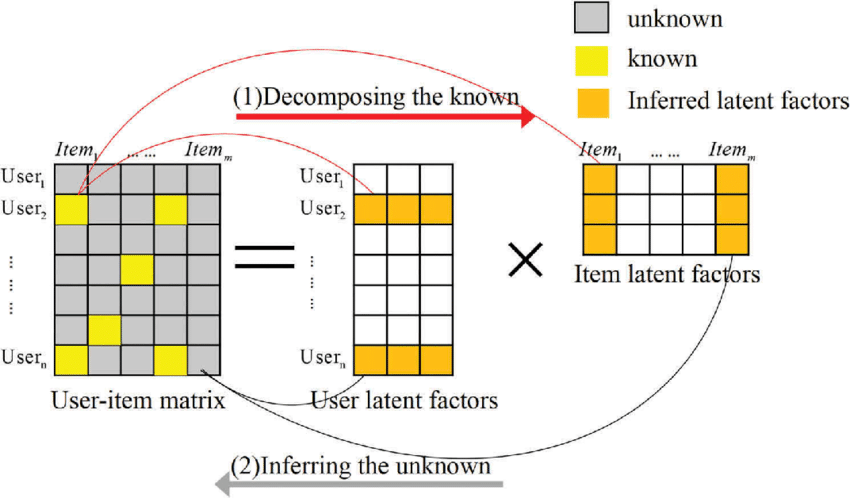

In [1]:
from IPython.display import Image,display
Image("../input/mat-fact/Diagram-of-matrix-factorization.png")

This is an ongoing work and I will add more details to this. Please upvote if you found this useful.


**Credits
* http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf
* https://github.com/jeffheaton/t81_558_deep_learning
* https://www.kaggle.com/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization
* https://beckernick.github.io/matrix-factorization-recommender/
* https://www.kaggle.com/vikashrajluhaniwal/matrix-factorization-recommendation-using-pyspark

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from scipy.sparse.linalg import svds
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.image as mpimgimport 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
from statistics import mean
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import shuffle  
from zipfile import ZipFile
##Deep Learning specific stuff
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Concatenate
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import dot
from tensorflow.keras.models import Model



# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
book_rating = pd.DataFrame()
for file in glob.glob("../input/goodreads-book-datasets-10m/book*.csv"):
    df = pd.read_csv(file)
    if book_rating.empty:
        book_rating = df
    else:
        book_rating.append(df, ignore_index=True)

        
user_rating = pd.DataFrame()
for file in glob.glob("../input/goodreads-book-datasets-10m/user_rating*.csv"):
    df = pd.read_csv(file)
    if user_rating.empty:
        user_rating = df
    else:
        user_rating.append(df, ignore_index=True)

In [4]:
book_rating.shape,user_rating.shape

((49843, 20), (46970, 3))

Let's take a quick look at the two tables

In [5]:
book_rating.head(3)

,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description,Count of text reviews
0,800001,"A Long Finish (Aurelio Zen, #6)",Michael Dibdin,0375404295,3.78,1998,25,8,Pantheon,5:216,4:460,3:302,2:48,1:17,total:1043,4,NaN,261,"After a riotous and heroic stint in Naples, Ze...",4
1,800002,"Blood Rain (Aurelio Zen, #7)",Michael Dibdin,0375708308,3.75,2001,8,5,Vintage Crime/Black Lizard,5:202,4:457,3:286,2:61,1:18,total:1024,4,NaN,288,"Aurelio Zen—cynical and tough, yet worn down f...",4
2,800003,"Sizilianisches Finale (Aurelio Zen, #7)",Michael Dibdin,3442450888,3.75,2001,1,12,Goldmann,5:202,4:457,3:286,2:61,1:18,total:1024,0,ger,320,Nachdem er seinen letzten Fall zwischen den sa...,0


In [6]:
user_rating.head()

,ID,Name,Rating
0,3182,Rating,This user doesn't have any rating
1,3183,Rating,This user doesn't have any rating
2,3187,Rating,This user doesn't have any rating
3,3188,Rating,This user doesn't have any rating
4,3191,Rating,This user doesn't have any rating


In [7]:
user_rating['Rating'].unique()

array(["This user doesn't have any rating", 'it was ok', 'liked it',
       'really liked it', 'it was amazing', 'did not like it'],
      dtype=object)

For the purpose of illustrating Collaborative filetring, we can use user_rating as it is in the format where we have Users who have rated specific books. We will skip the cases where there is no book name and no rating as well (as shown in the first few rows)

In [8]:
print("Number of unique users in the user_rating table :"+str(user_rating['ID'].nunique()))

Number of unique users in the user_rating table :968


The ratings are given in sentences, let's convert them to numeric field on a scale of 0-5 (where 0=No rating)

In [9]:
le = preprocessing.LabelEncoder()
user_rating['Rating_numeric'] = le.fit_transform(user_rating.Rating.values)
user_rating.tail()

,ID,Name,Rating,Rating_numeric
46965,4278,A Short History of Philosophy,liked it,4
46966,4278,Profit Over People: Neoliberalism & Global Order,liked it,4
46967,4278,Controversies In American Public Policy,liked it,4
46968,4278,Brazil: Politics in a Patrimonial Society,liked it,4
46969,4278,Mexican Politics: The Dynamics of Change,liked it,4


In [10]:
user_rating.head()

,ID,Name,Rating,Rating_numeric
0,3182,Rating,This user doesn't have any rating,0
1,3183,Rating,This user doesn't have any rating,0
2,3187,Rating,This user doesn't have any rating,0
3,3188,Rating,This user doesn't have any rating,0
4,3191,Rating,This user doesn't have any rating,0


**Creating Training and Validation set for the recommender system**

for this purpose, we first take only those customers whose ratings are > 0 i.e. they have given some sort of rating
and then take a random sample out of them i.e. we hide few of the previously rated books as the test set. Let's see an 
example of how this is to be done.

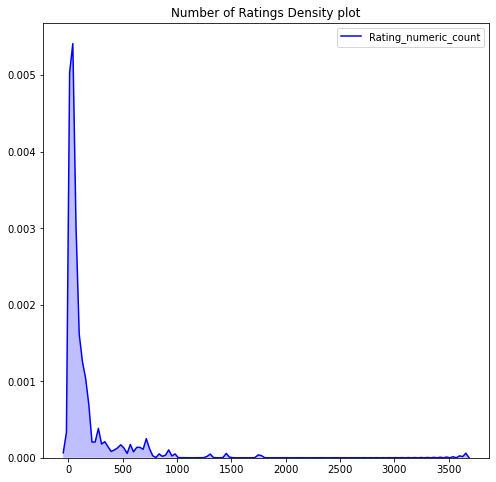

In [11]:
user_rating_pos = user_rating[user_rating['Rating_numeric']>0]
user_rating_zero = user_rating[user_rating['Rating_numeric']==0]
pos_rating_summary=user_rating_pos[['ID', 'Rating_numeric']].groupby(['ID']).agg(['count'])
pos_rating_summary.columns = ['_'.join(col) for col in pos_rating_summary.columns.values]
pos_rating_summary.reset_index(inplace=True)
plt.figure(figsize = (8, 8))
plt.title('Number of Ratings Density plot')
sns.kdeplot(pos_rating_summary['Rating_numeric_count'], color="blue", shade=True)
plt.show()

There seems to be a long tail, where some customers do provide a large number of ratings, whereas bulk of the people seem to have more than 5 ratings at least. Let's do a quick check to confirm this

In [12]:
kk = (len(pos_rating_summary[pos_rating_summary['Rating_numeric_count']>=5])/len(pos_rating_summary))*100
print("Percentage of people with 5 or more reviews: "+ str(kk))

Percentage of people with 5 or more reviews: 77.23404255319149


We will choose our test train split from these set of users who have atleast 5 or more reviews. This will ensure that if we take a 80-20 split, we have atleast 1 book that is held out for test predictions

In [13]:
eligible_customer_list = pos_rating_summary[pos_rating_summary['Rating_numeric_count']>=5].ID.tolist()
user_rating_eligible = user_rating_pos[user_rating_pos.ID.isin(eligible_customer_list)]
user_rating_NotEligible = user_rating_pos[~user_rating_pos.ID.isin(eligible_customer_list)]
user_rating_NotEligible.shape,user_rating_eligible.shape,user_rating_pos.shape

((205, 4), (46267, 4), (46472, 4))

In [14]:
##Create test and train split
split_idx = np.random.rand(len(user_rating_eligible)) < 0.8
user_rating_train_temp = user_rating_eligible[split_idx]
user_rating_test = user_rating_eligible[~split_idx]
user_rating_train = user_rating_train_temp.append(user_rating_NotEligible, ignore_index=True)
user_rating_train.shape, user_rating_train_temp.shape,user_rating_NotEligible.shape

((37263, 4), (37058, 4), (205, 4))

In [15]:
user_rating_train.head()

,ID,Name,Rating,Rating_numeric
0,3474,Hooked: How to Build Habit-Forming Products,it was ok,3
1,3259,Of Mice and Men,it was ok,3
2,3380,Of Mice and Men,really liked it,5
3,3448,Of Mice and Men,really liked it,5
4,3485,Of Mice and Men,liked it,4


**Data Pre-processing for Matrix Factorization**

For using SVD to do Matrix Factorization we need to convert it into wide format from Long format.

In [16]:
nb_users  = user_rating_train['ID'].nunique()
nb_books = user_rating_train['Name'].nunique()

print("There are %d unique users and %d unique books; so we need to prepare " 
      "an matrix of size %d by %d." %(nb_users, nb_books, nb_users, nb_books))

There are 470 unique users and 21793 unique books; so we need to prepare an matrix of size 470 by 21793.


In [17]:
user_rating_wide = user_rating_train.pivot(index = 'ID', columns ='Name', values = 'Rating_numeric').fillna(0)
user_rating_wide.head()

Name,"""A Problem from Hell"": America and the Age of Genocide","""Beat"" Takeshi Kitano","""Repent, Harlequin!"" Said the Ticktockman","""Sweat""","""The Greatest Invention In The History Of Mankind Is Beer"" And Other Manly Insights From Dave Barry",& Sons,'Art','Salem's Lot,"'Til Death Do Us Part (Bailey Weggins Mystery, #3)",'Tis,...,"東京喰種トーキョーグール 12 [Tokyo Guru 12] (Tokyo Ghoul, #12)","東京喰種トーキョーグール 13 [Tokyo Guru 13] (Tokyo Ghoul, #13)","東京喰種トーキョーグール 14 [Tokyo Guru 14] (Tokyo Ghoul, #14)","東京喰種トーキョーグール 2 [Tokyo Guru 2] (Tokyo Ghoul, #2)","東京喰種トーキョーグール 5 [Tokyo Guru 5] (Tokyo Ghoul, #5)","東京喰種トーキョーグール 6 [Tokyo Guru 6] (Tokyo Ghoul, #6)","東京喰種トーキョーグール 7 [Tokyo Guru 7] (Tokyo Ghoul, #7)","東京喰種トーキョーグール 8 [Tokyo Guru 8] (Tokyo Ghoul, #8)",海辺のカフカ Vol.2,為了N
ID,,,,,,,,,,,,,,,,,,,,,
3180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
user_rating_matrix = user_rating_wide.to_numpy()
user_ratings_mean = np.mean(user_rating_matrix, axis = 1)
user_rating_matrix_dm = user_rating_matrix - user_ratings_mean.reshape(-1, 1) ##Normalizing the ratings here, one can try a version without
                                                                              ##this and see if the recommendations are any better/worse

Let's do matrix factorization using SVD now

In [19]:
## k is a hyperparam here
## U and V are User latent matrix and V is Books latent matrix in our case
U, sigma, V = svds(user_rating_matrix_dm, k = 100)

In [20]:
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), V) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_rating_wide.columns)


In [21]:
kk=pd.DataFrame(user_rating_wide.index.values)
kk.rename(columns={ kk.columns[0]: "ID" }, inplace = True)
preds_df=pd.concat([kk,preds_df],axis=1)
preds_df.rename(columns={ preds_df.columns[0]: "ID" }, inplace = True)
preds_df

,ID,"""A Problem from Hell"": America and the Age of Genocide","""Beat"" Takeshi Kitano","""Repent, Harlequin!"" Said the Ticktockman","""Sweat""","""The Greatest Invention In The History Of Mankind Is Beer"" And Other Manly Insights From Dave Barry",& Sons,'Art','Salem's Lot,"'Til Death Do Us Part (Bailey Weggins Mystery, #3)",...,"東京喰種トーキョーグール 12 [Tokyo Guru 12] (Tokyo Ghoul, #12)","東京喰種トーキョーグール 13 [Tokyo Guru 13] (Tokyo Ghoul, #13)","東京喰種トーキョーグール 14 [Tokyo Guru 14] (Tokyo Ghoul, #14)","東京喰種トーキョーグール 2 [Tokyo Guru 2] (Tokyo Ghoul, #2)","東京喰種トーキョーグール 5 [Tokyo Guru 5] (Tokyo Ghoul, #5)","東京喰種トーキョーグール 6 [Tokyo Guru 6] (Tokyo Ghoul, #6)","東京喰種トーキョーグール 7 [Tokyo Guru 7] (Tokyo Ghoul, #7)","東京喰種トーキョーグール 8 [Tokyo Guru 8] (Tokyo Ghoul, #8)",海辺のカフカ Vol.2,為了N
0,3180,-0.000398,0.000428,0.000860,0.003890,-0.001232,0.002263,0.000339,-0.000224,-0.001396,...,0.001664,0.001664,0.001664,0.001664,0.001664,0.001664,0.001664,0.001664,-0.007498,-0.007679
1,3181,0.000209,0.000682,0.000676,0.000188,0.000508,0.000557,0.000578,-0.001633,0.000386,...,0.000203,0.000203,0.000203,0.000203,0.000203,0.000203,0.000203,0.000203,0.000795,0.000793
2,3184,-0.027953,-0.000168,0.000358,-0.005127,0.005918,0.006590,-0.001529,-0.004173,-0.001870,...,0.000643,0.000643,0.000643,0.000643,0.000643,0.000643,0.000643,0.000643,0.041988,-0.006311
3,3185,0.000921,-0.000082,0.002462,0.000125,0.000768,0.000351,0.000076,0.005574,0.000047,...,-0.000232,-0.000232,-0.000232,-0.000232,-0.000232,-0.000232,-0.000232,-0.000232,0.000137,0.000181
4,3186,0.043561,-0.010195,0.007534,0.016100,0.109094,-0.055686,-0.004252,0.006725,-0.009595,...,-0.001930,-0.001930,-0.001930,-0.001930,-0.001930,-0.001930,-0.001930,-0.001930,0.023445,-0.034485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,4270,0.005446,-0.002656,0.000448,-0.005381,-0.003623,-0.001609,-0.000887,-0.002703,-0.000820,...,0.007324,0.007324,0.007324,0.007324,0.007324,0.007324,0.007324,0.007324,-0.001284,0.003531
466,4274,-0.062481,0.003358,0.002740,0.045303,0.008446,0.011429,0.002221,0.001477,-0.007050,...,-0.004163,-0.004163,-0.004163,-0.004163,-0.004163,-0.004163,-0.004163,-0.004163,-0.006486,-0.027863
467,4278,-0.348191,0.007781,-0.000379,0.007969,0.050468,0.014051,0.005384,-0.006602,0.007814,...,0.002505,0.002505,0.002505,0.002505,0.002505,0.002505,0.002505,0.002505,0.077010,-0.027253
468,4284,-0.190191,-0.011077,-0.012992,0.034883,-0.159926,-0.020858,0.012602,0.024827,0.013149,...,0.028854,0.028854,0.028854,0.028854,0.028854,0.028854,0.028854,0.028854,-0.026862,-0.040415


**Compare the predictions**

We will compare th overlap of recommendations at Top-k with the hold out set and see how the recommender system performed in general.

Why do we do choose such a measure, instead of other metrics like MAE to compare absolute ratings?


Let's look at a sample book recommender at one of India's largest e-retailer (flipkart)

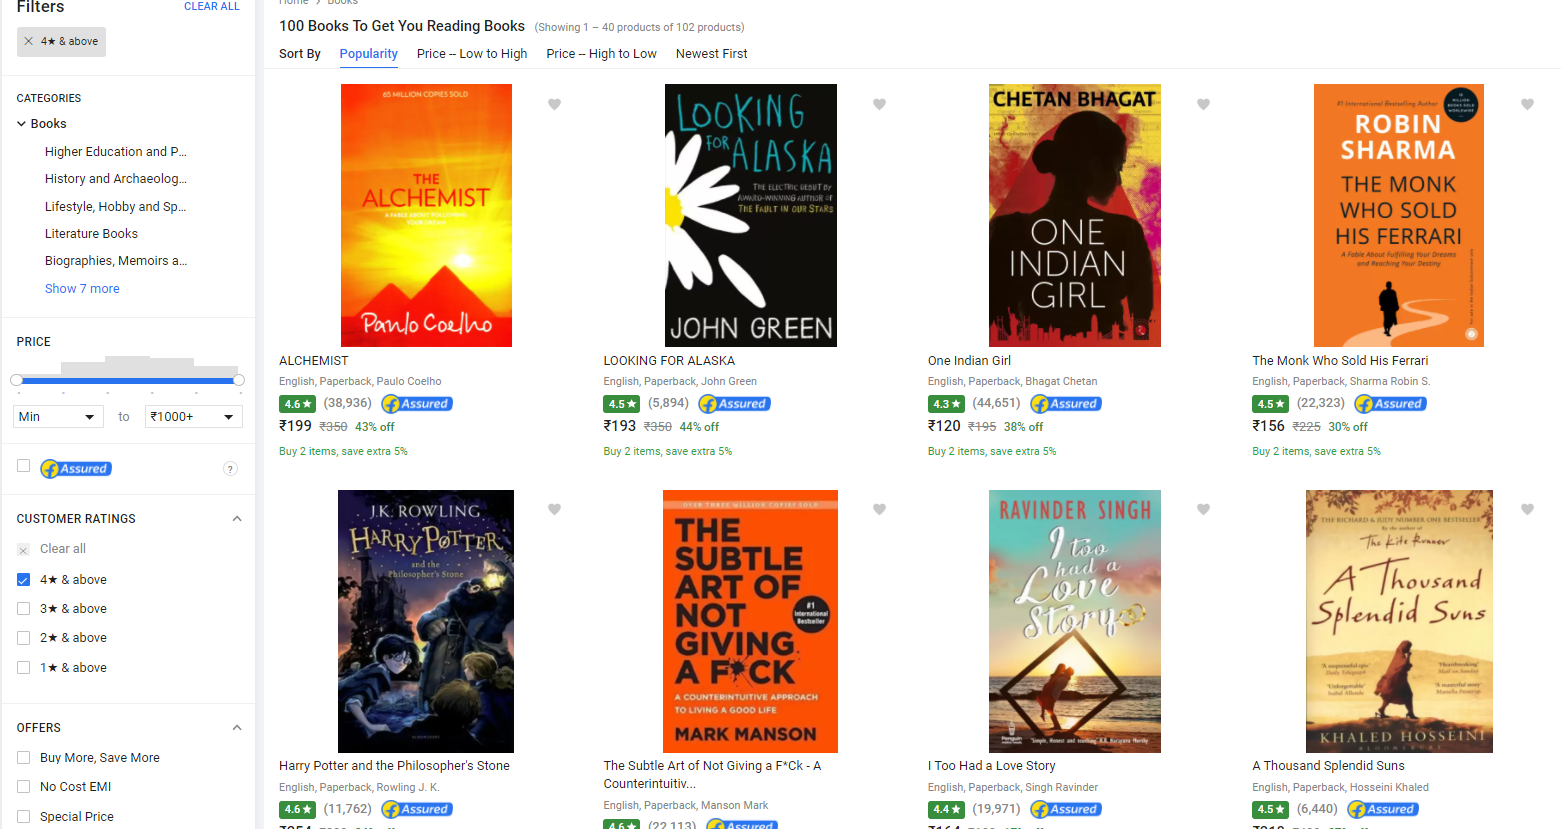

In [22]:
Image("../input/bookrecoflp/Book-reco-flipkart.PNG")

As you may see that actual ratings are whole numbers between (1-5), and we have filtered for 4-start reviews only in the example above. The ordering of the recommendation is not just a function of average rating. From the point of deploying the recommendation in production, its always done in a way where a multiple books are shown at once (8-12 typically based on the UI). Thus in many practical applications, one is interested if the top-K (in our example case k=8) overlap and as long as we can get maximum coverage, the relative order doesn't matter.



p.s. * - the opinion on evaluation metric in this case is purely based on my personal exp of having worked on many large scale industrial recommender systems that span across Manufacturing, QSR, Restaurant, e-commerce and Finanacial services. Others may disgaree to this.

In [23]:
##Function for checking overlap for one specific user
def check_overlap(UserId,top_recos_to_check):
    samp_cust = user_rating_test[user_rating_test['ID']==UserId]
    samp_cust.sort_values(by='Rating_numeric', ascending=False, inplace=True)
    book_name_testcust = samp_cust.Name.unique().tolist()
    available_actual_ratings = samp_cust.shape[0]
    rows_to_fetch = min(available_actual_ratings,top_recos_to_check)
    preds_df_sampcust = preds_df[preds_df['ID']==UserId]
    if preds_df_sampcust.shape[0] ==0:
        pass
    elif preds_df_sampcust.shape[0] >0:
        preds_check_cust = preds_df_sampcust.T
        preds_check_cust.reset_index(inplace=True)
        preds_check_cust.rename(columns={ preds_check_cust.columns[0]: "Name" }, inplace = True)
        #preds_check_cust = preds_df_sampcust_T[preds_df_sampcust_T['Name']!='ID']
        preds_check_cust.rename(columns={ preds_check_cust.columns[1]: "Ratings_normalized_predicted" }, inplace = True)
        preds_check_cust.sort_values(by='Ratings_normalized_predicted', ascending=0, inplace=True)
        preds_check_cust_check = preds_check_cust[preds_check_cust.Name.isin(book_name_testcust)]
        actual_rating = samp_cust.iloc[0:rows_to_fetch,:]
        pred_rating = preds_check_cust_check.iloc[0:rows_to_fetch,:]
        overlap = pd.Series(list(set(actual_rating.Name).intersection(set(pred_rating.Name))))
        pct_overlap = (len(overlap)/rows_to_fetch)*100
        #print("Percentage of overlap in top"+str(top_recos_to_check)+" for User ID - "+str(UserId)+" : "+str(pct_overlap))
        return pct_overlap

In [24]:
test_user_list = user_rating_test.ID.unique().tolist()
overlap_summary={}
top_recos_to_check =10
for users in test_user_list:
    if check_overlap(users,top_recos_to_check) is not None:
        overlap_summary[users]= check_overlap(users,top_recos_to_check)

In [25]:
sorted_summary = sorted(overlap_summary.items(), key=lambda x: x[1], reverse=True)
max_overlap = np.array(list(overlap_summary.values())).max()
min_overlap = np.array(list(overlap_summary.values())).min()
mean_overlap = np.array(list(overlap_summary.values())).mean()
print("Max overlap in top" +str(top_recos_to_check)+ " books "+str(max_overlap))
print("Min overlap in top "+str(top_recos_to_check)+ " books "+str(min_overlap))
print("Average overlap in top "+str(top_recos_to_check)+ " books "+str(mean_overlap))

Max overlap in top10 books 100.0
Min overlap in top 10 books 0.0
Average overlap in top 10 books 56.460385878489326


Thus, on an average we are able to recommend the right books decent number of the times. This was set up with very little effort. Let's see if we can improve this further by using Alternating Least Squares.

For this we will use Pyspark where there is a very good implementation of ALS

**Alternating Least Squares**

In any matrix factorization problem, we are trying to find out a relatively small number *k* and approximate each user *u* with a 
*k* dimensional vector *xu* and each book *i* with a *k* dimensional vector *yi* . These vectors are referred as factors. Then to predict user *u*s rating for book *i* , we simply predict *r~xu.Tyi* . In matrix notation it looks like as follows:



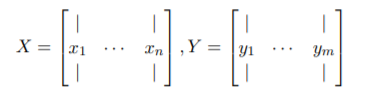

In [26]:
Image("../input/alspics/x-y-individual.PNG")

To estimate complete ratings, this is formulated as an optimization excercise (given below). Here we minimize the least squared errors of the observed ratings (along with regularization term)

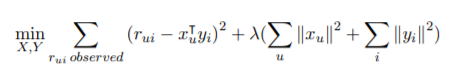

In [27]:
Image("../input/alspics/als-loss-function.PNG")

Notice that this objective function is non-convex and is NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables X and treat them as constants, then the objective is a convex function of Y and vice versa. In ALS, we fix Y and optimize X, then fix X and optimize Y , and repeat until convergence (algo shown below in picture)

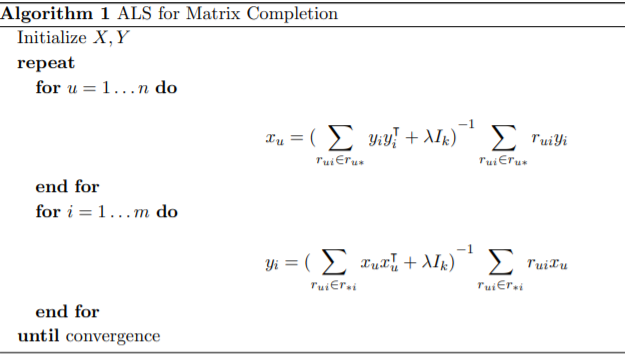

In [28]:
Image("../input/alspics/als-algo.PNG")

In [29]:
!pip install pyspark       #installing pyspark

     |████████████████████████████████| 204.2 MB 31 kB/s 
     |████████████████████████████████| 198 kB 25.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=958cd331096e0adf8956953b6471468ccb45102aaf81bc5cba269f066683d9f3
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [30]:
from pyspark import SparkContext, SQLContext   # required for dealing with dataframes
import numpy as np
from pyspark.ml.recommendation import ALS      # for Matrix Factorization using ALS 

In [31]:
sc = SparkContext()      # instantiating spark context 
sqlContext = SQLContext(sc) # instantiating SQL context 

For the ALS implementation in pyspark, user id and book ids need to be in Integer format. Let's create book id and create the required dataframe

In [32]:
book_names_train = user_rating_train[['Name']]
book_names_test = user_rating_test[['Name']]
book_name = pd.concat([book_names_train,book_names_test],axis=0)
book_name.drop_duplicates(inplace=True)
book_name['Book_id']= book_name.index.values
book_name.head()

,Name,Book_id
0,Hooked: How to Build Habit-Forming Products,0
1,Of Mice and Men,1
46,My Name Is Red,46
53,"The Da Vinci Code (Robert Langdon, #2)",53
126,Memoirs of a Geisha,126


In [33]:
user_rating_train = pd.merge(user_rating_train,book_name, on='Name',how='left')
user_rating_test = pd.merge(user_rating_test,book_name, on='Name',how='left')
user_rating_train.head()

,ID,Name,Rating,Rating_numeric,Book_id
0,3474,Hooked: How to Build Habit-Forming Products,it was ok,3,0
1,3259,Of Mice and Men,it was ok,3,1
2,3380,Of Mice and Men,really liked it,5,1
3,3448,Of Mice and Men,really liked it,5,1
4,3485,Of Mice and Men,liked it,4,1


In [34]:
user_rating_train_ = user_rating_train[['ID','Book_id','Rating_numeric']]
user_rating_test_ = user_rating_test[['ID','Book_id','Rating_numeric']]
user_rating_train_.head()

,ID,Book_id,Rating_numeric
0,3474,0,3
1,3259,1,3
2,3380,1,5
3,3448,1,5
4,3485,1,4


In [35]:
user_rating_train_.to_csv('user_rating_train.csv', index=False)
user_rating_test_.to_csv('user_rating_test.csv', index=False)
user_rating_train_sp = sqlContext.read.csv('user_rating_train.csv',header = True, inferSchema = True)
user_rating_test_sp = sqlContext.read.csv('user_rating_test.csv',header = True, inferSchema = True)

In [36]:
user_rating_train_sp.show(5)

+----+-------+--------------+
|  ID|Book_id|Rating_numeric|
+----+-------+--------------+
|3474|      0|             3|
|3259|      1|             3|
|3380|      1|             5|
|3448|      1|             5|
|3485|      1|             4|
+----+-------+--------------+
only showing top 5 rows



In [37]:
als = ALS(userCol="ID",itemCol="Book_id",ratingCol="Rating_numeric",rank=20, maxIter=10, seed=0, )
model = als.fit(user_rating_train_sp)

In [38]:
model.userFactors.show(5, truncate = False)  # displaying the latent features for five user

+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id  |features                                                                                                                                                                                                                                                       |
+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|3180|[0.041710112, 0.019051129, 0.31326526, 0.3362758, -0.9274635, 0.35665378, -0.2850881, -0.35330847, 0.39801586, -0.97284865, 0.25854585, -0.32177645, -0.08204267, -0.22319798, 0.033987403, 0.11444369, 0.575

In [39]:
predictions = model.transform(user_rating_test_sp[["ID","Book_id"]]) 

In [40]:
ratesAndPreds = user_rating_test_sp.join(other=predictions,on=['ID','Book_id'],how='inner').na.drop() 
ratesAndPreds.show(5)

+----+-------+--------------+----------+
|  ID|Book_id|Rating_numeric|prediction|
+----+-------+--------------+----------+
|4200|   1591|             2| 3.7924898|
|3216|   1591|             5| 3.3859258|
|3774|   1591|             4|  4.656951|
|4136|   1591|             5| 1.7303516|
|3833|   1591|             2| 3.7239623|
+----+-------+--------------+----------+
only showing top 5 rows



In [41]:
# converting the columns into numpy arrays for direct and easy calculations 
rating = np.array(ratesAndPreds.select("Rating_numeric").collect()).ravel()
prediction = np.array(ratesAndPreds.select("prediction").collect()).ravel()
print("RMSE : ", np.sqrt(np.mean((rating - prediction)**2)))

RMSE :  1.9319650985812586


In [42]:
avp_als= ratesAndPreds.toPandas()
avp_als.head()

,ID,Book_id,Rating_numeric,prediction
0,4200,1591,2,3.792490
1,3216,1591,5,3.385926
2,3774,1591,4,4.656951
3,4136,1591,5,1.730352
4,3833,1591,2,3.723962


In [43]:
def check_overlap(UserId,top_recos_to_check):
    samp_cust = avp_als[avp_als['ID']==UserId][['ID','Rating_numeric','Book_id']]
    samp_cust.sort_values(by='Rating_numeric', ascending=False, inplace=True)
    available_actual_ratings = samp_cust.shape[0]
    rows_to_fetch = min(available_actual_ratings,top_recos_to_check)
    preds_df_sampcust = avp_als[avp_als['ID']==UserId][['ID','prediction','Book_id']]
    preds_df_sampcust.sort_values(by='prediction', ascending=False, inplace=True)
    actual_rating = samp_cust.iloc[0:rows_to_fetch,:]
    pred_rating = preds_df_sampcust.iloc[0:rows_to_fetch,:]
    overlap = pd.Series(list(set(actual_rating.Book_id).intersection(set(pred_rating.Book_id))))
    pct_overlap = (len(overlap)/rows_to_fetch)*100
    #print("Percentage of overlap in top"+str(top_recos_to_check)+" for User ID - "+str(UserId)+" : "+str(pct_overlap))
    return pct_overlap

In [44]:
test_user_list = avp_als.ID.unique().tolist()
overlap_summary={}
top_recos_to_check =10
for users in test_user_list:
    overlap_summary[users]= check_overlap(users,top_recos_to_check)

In [45]:
sorted_summary = sorted(overlap_summary.items(), key=lambda x: x[1], reverse=True)
max_overlap = np.array(list(overlap_summary.values())).max()
min_overlap = np.array(list(overlap_summary.values())).min()
mean_overlap = np.array(list(overlap_summary.values())).mean()
print("Max overlap in top" +str(top_recos_to_check)+ " books "+str(max_overlap))
print("Min overlap in top "+str(top_recos_to_check)+ " books "+str(min_overlap))
print("Average overlap in top "+str(top_recos_to_check)+ " books "+str(mean_overlap))

Max overlap in top10 books 100.0
Min overlap in top 10 books 0.0
Average overlap in top 10 books 77.23032069970846


Now, that's a huge improvement from where we started using plain vanilla Matrix Factorization using SVD.

Let's see if we doing Matrix factorization using a Deep Neural network does anything better.

**Let's do MF using Deep Learning**

Before we jump into creating the network to mimic Matrix Factorization, let's understand the building blocks in a bit more details. The most crucial piece in this is the Embedding layer. The piece that we are referring to is 'tf.keras.layers.Embedding'.

People most often use Embedding layer in case of sequences, but that doesn't always have to be the case.
Here the first argument is input_dim, i.e. input dimension size. In our case when we create embedding for users
the input dimension is the number of unique users, which we encode into a lower numbered vectors (it's almost similar to 
dimension reduction execrcise). In our case there isn't anything for input_length as that is useful for sequences (like in NLP 
use cases). Think of the embedding layer as a look up table. Let's understand this in bit more details.

In [46]:
model = Sequential()
embedding_layer = Embedding(input_dim=10, output_dim=4, input_length=2)
model.add(embedding_layer)
model.compile('adam', 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 4)              40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


For this neural network, which is just an embedding layer, the input is a vector of size 2. These two inputs are integer numbers from 0 to 9 (corresponding to the requested input_dim quantity of 10 values). Looking at the summary above, we see that the embedding layer has 40 parameters. This value comes from the embedded lookup table that contains four amounts (output_dim) for each of the 10 (input_dim) possible integer values for the two inputs. The output is 2 (input_length) length 4 (output_dim) vectors, resulting in a total output size of 8, which corresponds to the Output Shape given in the summary above.

Now, let us query the neural network with two rows. The input is two integer values, as was specified when we created the neural network.

In [47]:
input_data = np.array([
    [1,2]
])

pred = model.predict(input_data)

print(input_data.shape)
print(pred)

(1, 2)
[[[ 0.02647177  0.00902859 -0.0148051   0.03856771]
  [-0.02600663  0.04115874  0.01700499  0.01123903]]]


Here we see two length-4 vectors that Tensorflow looked up for each of the input integers. Recall that Python arrays are zero-based. Tensorflow replaced the value of 1 with the second row of the 10 x 4 lookup matrix. Similarly, Tensorflow replaced the value of 2 by the third row of the lookup matrix. The following code displays the lookup matrix in its entirety. The embedding layer performs no mathematical operations other than inserting the correct row from the lookup table.

In [48]:
embedding_layer.get_weights()

[array([[ 0.02286947,  0.03322772,  0.02361038, -0.0170625 ],
        [ 0.02647177,  0.00902859, -0.0148051 ,  0.03856771],
        [-0.02600663,  0.04115874,  0.01700499,  0.01123903],
        [ 0.02627346,  0.02673712,  0.00668269, -0.03011521],
        [-0.04080195, -0.02346987, -0.02225703, -0.02917331],
        [ 0.00352795,  0.01094273, -0.02689102, -0.00047337],
        [-0.02371625,  0.02337048,  0.0078587 ,  0.02555895],
        [-0.00144696,  0.03735581, -0.00042876,  0.04542748],
        [-0.02994751, -0.03352728, -0.03288339,  0.02127701],
        [ 0.02079642,  0.0232936 ,  0.04540731, -0.00608844]],
       dtype=float32)]

The values above are random parameters that Tensorflow generated as starting points. In our case the network trains these embeddings to learn values that are able to minimize the loss function. In our case we create embeddings for users and books, and then combine them using dot product (i.e. tf.keras.layers.dot) to simulate a case where we are trying minimize mean squared error to replicate the actual ratings. 

In [49]:
##Reading the datafiles again to avoid any confusion
book_rating = pd.DataFrame()
for file in glob.glob("../input/goodreads-book-datasets-10m/book*.csv"):
    df = pd.read_csv(file)
    if book_rating.empty:
        book_rating = df
    else:
        book_rating.append(df, ignore_index=True)

        
user_rating_temp = pd.DataFrame()
for file in glob.glob("../input/goodreads-book-datasets-10m/user_rating*.csv"):
    df = pd.read_csv(file)
    if user_rating_temp.empty:
        user_rating_temp = df
    else:
        user_rating_temp.append(df, ignore_index=True)

In [50]:
book_map = user_rating_temp[['Name']]
book_map.drop_duplicates(subset=['Name'],keep='first',inplace=True)
book_map['Book_Id']=book_map.index.values
user_rating_temp = pd.merge(user_rating_temp,book_map, on='Name', how='left')
user_rating = user_rating_temp[user_rating_temp['Name']!='Rating'] ##Dropping users who have not rated any books
user_rating.head()

,ID,Name,Rating,Book_Id
498,3474,Hooked: How to Build Habit-Forming Products,it was ok,498
499,3225,Of Mice and Men,liked it,499
500,3259,Of Mice and Men,it was ok,499
501,3380,Of Mice and Men,really liked it,499
502,3420,Of Mice and Men,really liked it,499


In [51]:
le = preprocessing.LabelEncoder()
user_rating['Rating_numeric'] = le.fit_transform(user_rating.Rating.values)
users = user_rating.ID.unique()
books = user_rating.Book_Id.unique()
##Train-test split  - keeping 80%-20% for simplicity. But one can create a k-fold set up for better accuracy as well
userid2idx = {o:i for i,o in enumerate(users)}
bookid2idx = {o:i for i,o in enumerate(books)}
user_rating['ID'] = user_rating['ID'].apply(lambda x: userid2idx[x])
user_rating['Book_Id'] = user_rating['Book_Id'].apply(lambda x: bookid2idx[x])
y=user_rating['Rating_numeric']
X=user_rating.drop(['Rating_numeric'],axis=1)
####
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape , X_test.shape)

(37177, 4) (9295, 4)


In [52]:
def build_model(dropout,latent_factors):
    n_books=len(user_rating['Book_Id'].unique())
    n_users=len(user_rating['ID'].unique())
    n_latent_factors=latent_factors  # hyperparamter to deal with. 
    user_input=Input(shape=(1,),name='user_input',dtype='int64')
    user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding',embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=42))(user_input)
    user_vec =Flatten(name='FlattenUsers')(user_embedding)
    user_vec=Dropout(dropout)(user_vec)
    book_input=Input(shape=(1,),name='book_input',dtype='int64')
    book_embedding=Embedding(n_books,n_latent_factors,name='book_embedding',embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=42))(book_input)
    book_vec=Flatten(name='FlattenBooks')(book_embedding)
    book_vec=Dropout(dropout)(book_vec)
    sim=dot([user_vec,book_vec],name='Similarity-Dot-Product',axes=1)
    nn_inp=Dense(128,activation='relu')(sim)
    nn_inp=Dropout(dropout)(nn_inp)
    nn_inp=Dense(64,activation='relu')(nn_inp)
    nn_inp=BatchNormalization()(nn_inp)
    nn_inp=Dense(1,activation='relu')(nn_inp)
    nn_model =Model([user_input, book_input],nn_inp)
    return nn_model
    

In [53]:
nn_model = build_model(0.4,65)
nn_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 65)        30550       user_input[0][0]                 
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 65)        1687140     book_input[0][0]                 
_______________________________________________________________________________________

In [54]:
nn_model.compile(optimizer=Adam(lr=1e-4),loss='mse')
batch_size=128
epochs=5
History = nn_model.fit([X_train.ID,X_train.Book_Id],y_train, batch_size=batch_size,
                              epochs =epochs, validation_data = ([X_test.ID,X_test.Book_Id],y_test),
                              verbose = 1)

Epoch 1/5
291/291 [==============================] - 5s 18ms/step - loss: 7.6375 - val_loss: 6.8790
Epoch 2/5
291/291 [==============================] - 5s 16ms/step - loss: 5.5791 - val_loss: 4.0068
Epoch 3/5
291/291 [==============================] - 4s 15ms/step - loss: 3.9106 - val_loss: 2.2228
Epoch 4/5
291/291 [==============================] - 5s 16ms/step - loss: 2.5382 - val_loss: 1.7269
Epoch 5/5
291/291 [==============================] - 5s 16ms/step - loss: 1.6581 - val_loss: 1.7362


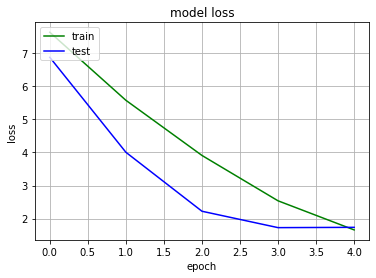

In [55]:
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [56]:
preds = nn_model.predict([X_test.ID,X_test.Book_Id])
avp = (preds,y_test)
df_id = pd.DataFrame(np.array(X_test.ID))
df_Book_id = pd.DataFrame(np.array(X_test.Book_Id))
df_actual_rating = pd.DataFrame(np.array(y_test))
df_preds = pd.DataFrame(preds)
dfList = [df_id, df_Book_id,df_actual_rating,df_preds]  # List of your dataframes
avp = pd.concat(dfList,ignore_index=True,axis=1)
#new_df = pd.concat([new_df,df_preds],ignore_index=True,axis=1)
avp.rename(columns={ avp.columns[0]: "ID" }, inplace = True)
avp.rename(columns={ avp.columns[1]: "Book_Id" }, inplace = True)
avp.rename(columns={ avp.columns[2]: "Rating_numeric" }, inplace = True)
avp.rename(columns={ avp.columns[3]: "Pred_Rating" }, inplace = True)
avp

,ID,Book_Id,Rating_numeric,Pred_Rating
0,157,5339,3,2.556454
1,21,482,0,2.660192
2,104,3389,4,2.657803
3,84,5685,1,2.464293
4,220,12722,4,2.335287
...,...,...,...,...
9290,2,11356,2,2.984712
9291,217,439,1,2.532367
9292,6,10037,4,2.775395
9293,51,1002,4,2.222755


In [57]:
def check_overlap(UserId,top_recos_to_check):
    samp_cust = avp[avp['ID']==UserId][['ID','Rating_numeric','Book_Id']]
    samp_cust.sort_values(by='Rating_numeric', ascending=False, inplace=True)
    available_actual_ratings = samp_cust.shape[0]
    rows_to_fetch = min(available_actual_ratings,top_recos_to_check)
    preds_df_sampcust = avp[avp['ID']==UserId][['ID','Pred_Rating','Book_Id']]
    preds_df_sampcust.sort_values(by='Pred_Rating', ascending=False, inplace=True)
    actual_rating = samp_cust.iloc[0:rows_to_fetch,:]
    pred_rating = preds_df_sampcust.iloc[0:rows_to_fetch,:]
    overlap = pd.Series(list(set(actual_rating.Book_Id).intersection(set(pred_rating.Book_Id))))
    pct_overlap = (len(overlap)/rows_to_fetch)*100
    #print("Percentage of overlap in top"+str(top_recos_to_check)+" for User ID - "+str(UserId)+" : "+str(pct_overlap))
    return pct_overlap

In [58]:
test_user_list = avp.ID.unique().tolist()
overlap_summary={}
top_recos_to_check =10
for users in test_user_list:
    overlap_summary[users]= check_overlap(users,top_recos_to_check)

In [59]:
sorted_summary = sorted(overlap_summary.items(), key=lambda x: x[1], reverse=True)
max_overlap = np.array(list(overlap_summary.values())).max()
min_overlap = np.array(list(overlap_summary.values())).min()
mean_overlap = np.array(list(overlap_summary.values())).mean()
print("Max overlap in top" +str(top_recos_to_check)+ " books "+str(max_overlap))
print("Min overlap in top "+str(top_recos_to_check)+ " books "+str(min_overlap))
print("Average overlap in top "+str(top_recos_to_check)+ " books "+str(mean_overlap))

Max overlap in top10 books 100.0
Min overlap in top 10 books 0.0
Average overlap in top 10 books 75.71428571428571


That's a huge improvement in the accuracy of recommendations by just switching to a different way of doing low rank matrix factorization using a deep neural network. Now we are able to recommend almost 3 out of 4 books correctly to the user.

Further improvments can be made by playing around with network architecture.